[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Yang_et_al_2018/fig_2.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Yang_et_al_2018/fig_2.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Yang_et_al_2018/fig_2.ipynb)

#### based on Fig. 2 from Yang et al. 2018 (Atmos. Chem. Phys. 18)  "_Cloud droplet size distribution broadening during diffusional growth: ripening amplified by deactivation and reactivation_"   
https://doi.org/10.5194/acp-18-7313-2018

In [1]:
import os, sys
os.environ['NUMBA_THREADING_LAYER'] = 'workqueue'  # PySDM & PyMPDATA don't work with TBB; OpenMP has extra dependencies on macOS
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples', 'PySDM')

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from open_atmos_jupyter_utils import show_plot
from PySDM_examples.Yang_et_al_2018 import Simulation, Settings
from PySDM.physics.constants import PER_CENT, si, in_unit

In [3]:
ix51 = 40
ix503 = 99

In [4]:
def runner():
    settings = Settings(dt_output=10 * si.minutes)

    assert int(round(in_unit(settings.r_dry[ix51],  si.nm))) == 51
    assert int(round(in_unit(settings.r_dry[ix503], si.nm))) == 503

    output = Simulation(settings).run()
    mass = settings.mass_of_dry_air
    result = {
        'r_bins_edges': settings.r_bins_edges,
        'n': settings.n / mass,
        'dt_max': settings.dt_max,
        'rtol_thd': settings.rtol_thd,
        'rtol_x': settings.rtol_x,
    }
    array_keys = (
        'r_mean_gt_1_um', 'z', 'S', 't', 'T',
        'r_act', 'r_bins_values', 'r',
    )

    result.update({k: output[k] for k in array_keys})
    result['liquid_water_mixing_ratio'] = (
            output["water_vapour_mixing_ratio"][0] - output["water_vapour_mixing_ratio"]
    )
    result['r_bins_values'] = result['r_bins_values'].T / mass
    result['r'] = result['r'].T
    return result


In [5]:
out = runner()

### Thermodynamical and microphysical properties of an adiabatic cloud parcel with upward and downward oscillations. 
Fig. 2, subplots a, b & c   
(a) Liquid water mixing ratio changes with height.  
(b) Cloud parcel saturation ratio changes with height.  
(c) Radii changes of two selected cloud droplets with height.

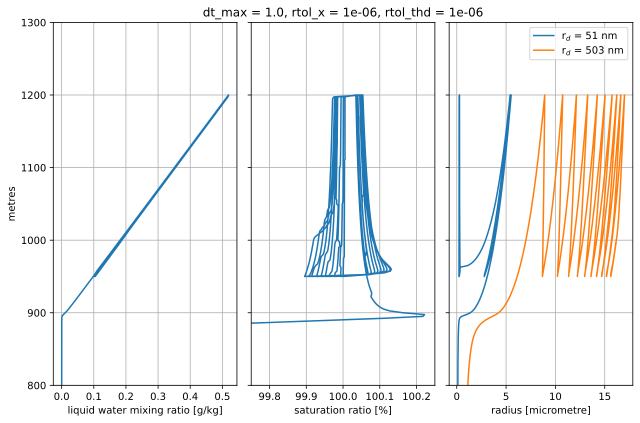

In [6]:
figsize=(9,6)
fig, ax = plt.subplots(1, 3, sharey=True, figsize=figsize)
    
xunit_q = si.gram / si.kilogram
xunit_S = PER_CENT
xunit_r = si.um

z = out['z']
tols = f"rtol_x = {out['rtol_x']}, rtol_thd = {out['rtol_thd']}"

ax[0].plot(in_unit(out['liquid_water_mixing_ratio'], xunit_q), z)
ax[0].set(
    xlabel='liquid water mixing ratio [g/kg]',
    ylim=[800, 1300],
    ylabel="metres"
)
ax[1].plot(in_unit(out['S']+1, xunit_S), z)
ax[1].set(
    xlabel="saturation ratio [%]",
    xlim=[99.75, 100.25],
    title=f"dt_max = {out['dt_max']}, "+tols
)
ax[2].plot(
    in_unit(out['r'][ix51], xunit_r), z,
    label="r$_d$ = 51 nm"
)
ax[2].plot(
    in_unit(out['r'][ix503], xunit_r), z,
    label="r$_d$ = 503 nm"
)
ax[2].set(xlabel="radius [micrometre]")
ax[2].legend()

for a in ax:
    a.grid()

fig.tight_layout()
show_plot(filename='q_S_rd.pdf')

### Cloud droplet size distribution (CDSD) changes with time
Fig. 2, subplot d

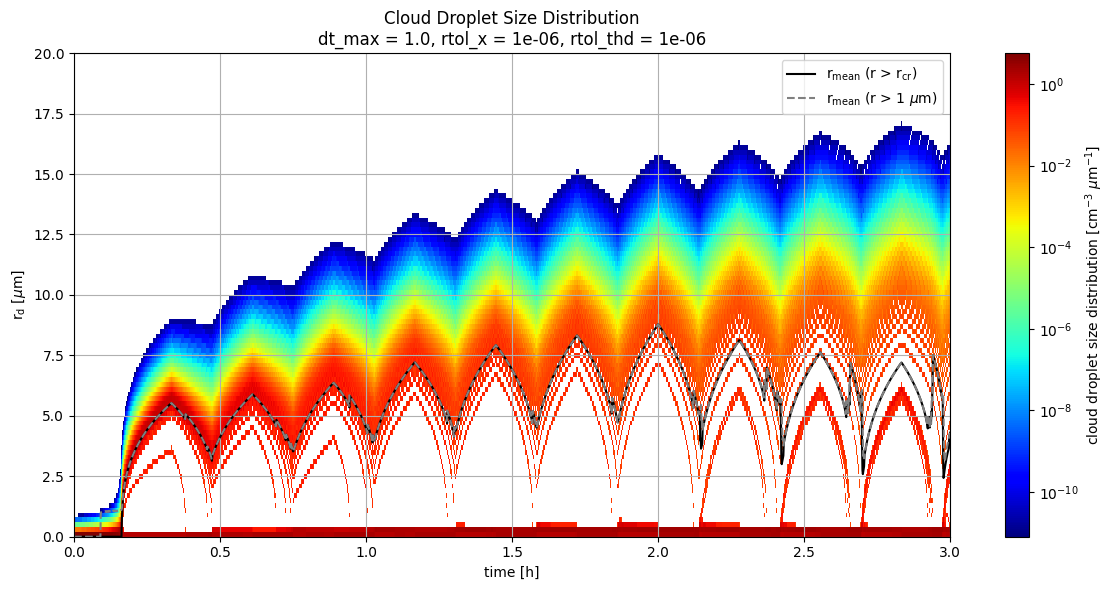

In [7]:
figsize=(12, 6)
fig, ax = plt.subplots(figsize=figsize)

xunit, yunit, hist_unit = si.hour, si.micrometres, si.cm**-3 * si.um**-1
tols = f"rtol_x = {out['rtol_x']}, rtol_thd = {out['rtol_thd']}"
x_edges = out['t']
y_edges = out['r_bins_edges']
hist = out['r_bins_values']
hist = 0.5 * (hist[:, :-1] + hist[:, 1:])

cm = ax.pcolormesh(
    in_unit(x_edges, xunit),
    in_unit(y_edges, yunit),
    in_unit(hist, hist_unit),
    cmap="jet",
    norm=mpl.colors.LogNorm()
)
ax.plot(
    in_unit(out['t'], xunit),
    in_unit(out["r_act"], yunit),
    color="black",
    label=r"r$_\text{mean}$ (r > r$_\text{cr}$)",
)
ax.plot(
    in_unit(out['t'], xunit),
    in_unit(out["r_mean_gt_1_um"], yunit),
    "--",
    color="gray",
    label=r"r$_\text{mean}$ (r > 1 $\mu$m)"
)
ax.set(
    ylabel=r'r$_\text{d}$ [$\mu$m]',
    xlabel='time [h]',
    ylim=(0,20),
    title="Cloud Droplet Size Distribution\n" + rf"dt_max = {out['dt_max']}, {tols}"
)
ax.grid()
ax.legend(loc="upper right")

fig.tight_layout()
fig.colorbar(cm, label=r"cloud droplet size distribution [cm$^{-3}$ $\mu$m$^{-1}$]")

show_plot(filename='spectrum.pdf', inline_format='png')